# Tree-based Time Series Forecasting

Prepare a time series for tree-based supervised learning

Data source: [HomeStead(US) Electricity Consumption](https://www.kaggle.com/datasets/unajtheb/homesteadus-electricity-consumption?resource=download) from Kaggle

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/My Drive/data/time_series'
data = pd.read_csv(path + '/electric_consumption.csv')
data.tail()

,Date,Homestead_maxtempC,Homestead_mintempC,Homestead_DewPointC,Homestead_FeelsLikeC,Homestead_HeatIndexC,Homestead_WindChillC,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph,Consumption
22196,12/11/17 4:00,19,9,1,7,10,7,29,0,54,0.0,1024,10,10,342,17,46
22197,12/11/17 3:00,19,9,2,8,10,8,29,0,57,0.0,1024,10,10,339,16,52
22198,12/11/17 2:00,19,9,2,8,10,8,28,0,56,0.0,1024,10,10,338,16,55
22199,12/11/17 1:00,19,9,2,8,10,8,28,0,55,0.0,1024,10,10,337,16,56
22200,12/11/17 0:00,19,9,1,8,10,8,28,0,55,0.0,1024,10,10,335,16,56


In [ ]:
data.columns

Index(['Date', 'Homestead_maxtempC', 'Homestead_mintempC',
       'Homestead_DewPointC', 'Homestead_FeelsLikeC', 'Homestead_HeatIndexC',
       'Homestead_WindChillC', 'Homestead_WindGustKmph',
       'Homestead_cloudcover', 'Homestead_humidity', 'Homestead_precipMM',
       'Homestead_pressure', 'Homestead_tempC', 'Homestead_visibility',
       'Homestead_winddirDegree', 'Homestead_windspeedKmph', 'Consumption'],
      dtype='object')

In [ ]:
data.dtypes

Date                        object
Homestead_maxtempC           int64
Homestead_mintempC           int64
Homestead_DewPointC          int64
Homestead_FeelsLikeC         int64
Homestead_HeatIndexC         int64
Homestead_WindChillC         int64
Homestead_WindGustKmph       int64
Homestead_cloudcover         int64
Homestead_humidity           int64
Homestead_precipMM         float64
Homestead_pressure           int64
Homestead_tempC              int64
Homestead_visibility         int64
Homestead_winddirDegree      int64
Homestead_windspeedKmph      int64
Consumption                  int64
dtype: object

In [ ]:
df = data[['Date','Consumption']].copy()
df.columns = ['date','y']
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by='date')

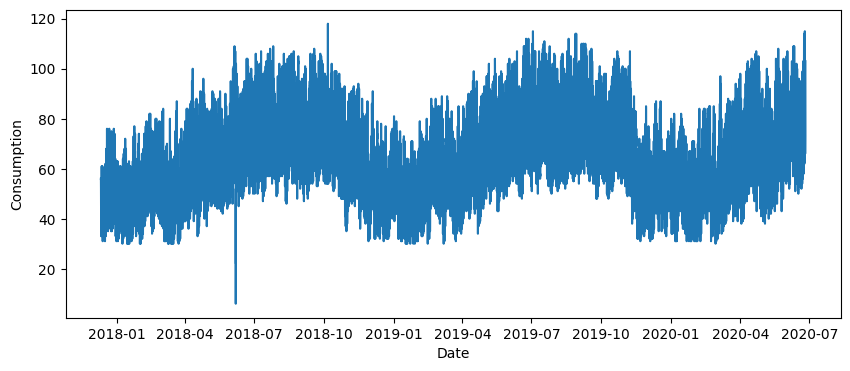

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['date'], df["y"])
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.show()

In [ ]:
df.head()

,date,y
22200,2017-12-11 00:00:00,56
22199,2017-12-11 01:00:00,56
22198,2017-12-11 02:00:00,55
22197,2017-12-11 03:00:00,52
22196,2017-12-11 04:00:00,46


## (1) Creating features

### (1.1) Creating lagged and future values

In [ ]:
ff = df.copy()
ff['y-1'] = ff['y'].shift(1)
ff['y-2'] = ff['y'].shift(2)
ff['y-3'] = ff['y'].shift(3)
ff.head()

,date,y,y-1,y-2,y-3
22200,2017-12-11 00:00:00,56,NaN,NaN,NaN
22199,2017-12-11 01:00:00,56,56.0,NaN,NaN
22198,2017-12-11 02:00:00,55,56.0,56.0,NaN
22197,2017-12-11 03:00:00,52,55.0,56.0,56.0
22196,2017-12-11 04:00:00,46,52.0,55.0,56.0


In [ ]:
ff = df.copy()

def create_lagged(df, n_vars):
  for i in range(n_vars):
    name = ('y-%d' % (i+1))
    df[name] = df['y'].shift(i+1)
  return df

ff = create_lagged(ff, 5)
ff.head()

,date,y,y-1,y-2,y-3,y-4,y-5
22200,2017-12-11 00:00:00,56,NaN,NaN,NaN,NaN,NaN
22199,2017-12-11 01:00:00,56,56.0,NaN,NaN,NaN,NaN
22198,2017-12-11 02:00:00,55,56.0,56.0,NaN,NaN,NaN
22197,2017-12-11 03:00:00,52,55.0,56.0,56.0,NaN,NaN
22196,2017-12-11 04:00:00,46,52.0,55.0,56.0,56.0,NaN


In [ ]:
ff = df.copy()
ff['y+1'] = ff['y'].shift(-1)
ff['y+2'] = ff['y'].shift(-2)
ff['y+3'] = ff['y'].shift(-3)
ff.tail()

,date,y,y+1,y+2,y+3
4,2020-06-25 13:00:00,73,82.0,74.0,99.0
3,2020-06-25 14:00:00,82,74.0,99.0,103.0
2,2020-06-25 15:00:00,74,99.0,103.0,NaN
1,2020-06-25 16:00:00,99,103.0,NaN,NaN
0,2020-06-25 17:00:00,103,NaN,NaN,NaN


In [ ]:
df = create_lagged(df, 25)
df.columns

Index(['date', 'y', 'y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6', 'y-7', 'y-8',
       'y-9', 'y-10', 'y-11', 'y-12', 'y-13', 'y-14', 'y-15', 'y-16', 'y-17',
       'y-18', 'y-19', 'y-20', 'y-21', 'y-22', 'y-23', 'y-24', 'y-25'],
      dtype='object')

### (1.2) Creating time-based features
- Pandas.Series.dt has many time-based features: https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.floor.html

In [ ]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df['quarter'] = df.date.dt.quarter
    df['hour_of_day'] = df.date.dt.hour
    df['weekday'] = df.date.dt.weekday
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    return df
df = create_date_features(df)
df.head()

<ipython-input-267-2834ed7b2f10>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df.date.dt.weekofyear


,date,y,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,...,year,quarter,hour_of_day,weekday,is_year_start,is_year_end,is_month_start,is_month_end,is_quarter_start,is_quarter_end
22200,2017-12-11 00:00:00,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,4,0,0,0,0,0,0,0,0
22199,2017-12-11 01:00:00,56,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,4,1,0,0,0,0,0,0,0
22198,2017-12-11 02:00:00,55,56.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2017,4,2,0,0,0,0,0,0,0
22197,2017-12-11 03:00:00,52,55.0,56.0,56.0,NaN,NaN,NaN,NaN,NaN,...,2017,4,3,0,0,0,0,0,0,0
22196,2017-12-11 04:00:00,46,52.0,55.0,56.0,56.0,NaN,NaN,NaN,NaN,...,2017,4,4,0,0,0,0,0,0,0


In [ ]:
to_dummy = ['weekday', 'month', 'quarter', 'year', 'day_of_month', 'week_of_year', 'day_of_week', 'hour_of_day']
df = pd.get_dummies(df, columns= to_dummy)

In [ ]:
df.columns

Index(['date', 'y', 'y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6', 'y-7', 'y-8',
       ...
       'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17',
       'hour_of_day_18', 'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21',
       'hour_of_day_22', 'hour_of_day_23'],
      dtype='object', length=175)

### (1.3) Creating moving average variables

In [ ]:
def roll_mean_features(df, windows):
    df = df.copy()
    for window in windows:
        df['mv_' + str(window)] = df['y'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=5, win_type="triang").mean())
    return df
df = roll_mean_features(df, [6, 9, 12, 15, 18, 21, 24])
df.tail()

,date,y,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,...,hour_of_day_21,hour_of_day_22,hour_of_day_23,mv_6,mv_9,mv_12,mv_15,mv_18,mv_21,mv_24
4,2020-06-25 13:00:00,73,67.0,66.0,67.0,66.0,67.0,70.0,73.0,79.0,...,0,0,0,66.722222,69.68,75.402778,83.015625,89.567901,94.000000,96.479167
3,2020-06-25 14:00:00,82,73.0,67.0,66.0,67.0,66.0,67.0,70.0,73.0,...,0,0,0,66.888889,68.24,72.180556,79.109375,85.598765,91.008264,94.454861
2,2020-06-25 15:00:00,74,82.0,73.0,67.0,66.0,67.0,66.0,67.0,70.0,...,0,0,0,68.500000,68.24,70.166667,76.000000,81.901235,87.925620,92.052083
1,2020-06-25 16:00:00,99,74.0,82.0,73.0,67.0,66.0,67.0,66.0,67.0,...,0,0,0,71.388889,69.00,69.333333,73.609375,78.679012,84.851240,89.409722
0,2020-06-25 17:00:00,103,99.0,74.0,82.0,73.0,67.0,66.0,67.0,66.0,...,0,0,0,75.722222,71.36,69.708333,72.343750,76.172840,82.140496,86.750000


In [ ]:
df[['date','mv_6','mv_9','mv_12','mv_15','mv_18', 'mv_21', 'mv_24']].tail()

,date,mv_6,mv_9,mv_12,mv_15,mv_18,mv_21,mv_24
4,2020-06-25 13:00:00,66.722222,69.68,75.402778,83.015625,89.567901,94.000000,96.479167
3,2020-06-25 14:00:00,66.888889,68.24,72.180556,79.109375,85.598765,91.008264,94.454861
2,2020-06-25 15:00:00,68.500000,68.24,70.166667,76.000000,81.901235,87.925620,92.052083
1,2020-06-25 16:00:00,71.388889,69.00,69.333333,73.609375,78.679012,84.851240,89.409722
0,2020-06-25 17:00:00,75.722222,71.36,69.708333,72.343750,76.172840,82.140496,86.750000


In [ ]:
df.columns

Index(['date', 'y', 'y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6', 'y-7', 'y-8',
       ...
       'hour_of_day_21', 'hour_of_day_22', 'hour_of_day_23', 'mv_6', 'mv_9',
       'mv_12', 'mv_15', 'mv_18', 'mv_21', 'mv_24'],
      dtype='object', length=182)

## (2) lightGBM
### (2.1) Train-test split

In [ ]:
from datetime import timedelta
num_days = (df['date'].max() - df['date'].min()).days
oot = num_days*0.2 # reserve 20% for out-of-time
cutdate = df['date'].max() - timedelta(days = oot)

In [ ]:
train = df.loc[(df['date'] <= cutdate), :]
print("Training data: from", train['date'].min(),"to", train['date'].max() )

test = df.loc[(df['date'] > cutdate), :]
print("Test data: from", test['date'].min(), "to", test['date'].max() )

Training data: from 2017-12-11 00:00:00 to 2019-12-23 07:00:00
Test data: from 2019-12-23 08:00:00 to 2020-06-25 17:00:00


In [ ]:
train.tail()

,date,y,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,...,hour_of_day_21,hour_of_day_22,hour_of_day_23,mv_6,mv_9,mv_12,mv_15,mv_18,mv_21,mv_24
4431,2019-12-23 03:00:00,65,67.0,67.0,66.0,62.0,59.0,59.0,60.0,59.0,...,0,0,0,63.555556,61.40,60.361111,58.562500,56.154321,53.776860,52.222222
4430,2019-12-23 04:00:00,62,65.0,67.0,67.0,66.0,62.0,59.0,59.0,60.0,...,0,0,0,65.333333,62.64,61.194444,59.781250,57.604938,55.148760,53.322917
4429,2019-12-23 05:00:00,56,62.0,65.0,67.0,67.0,66.0,62.0,59.0,59.0,...,0,0,0,65.944444,63.76,62.069444,60.765625,58.901235,56.462810,54.506944
4428,2019-12-23 06:00:00,50,56.0,62.0,65.0,67.0,67.0,66.0,62.0,59.0,...,0,0,0,64.944444,64.20,62.875000,61.484375,59.975309,57.652893,55.673611
4427,2019-12-23 07:00:00,46,50.0,56.0,62.0,65.0,67.0,67.0,66.0,62.0,...,0,0,0,62.277778,63.68,63.250000,61.906250,60.759259,58.644628,56.753472


### (2.2) Modeling

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
cols = [col for col in train.columns if col not in ['date', 'y']]
Y_train = train['y']
X_train = train[cols]
Y_test = test['y']
X_test = test[cols]

In [ ]:
X_train.columns[160:200]

Index(['hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
       'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17', 'hour_of_day_18',
       'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21', 'hour_of_day_22',
       'hour_of_day_23', 'mv_6', 'mv_9', 'mv_12', 'mv_15', 'mv_18', 'mv_21',
       'mv_24'],
      dtype='object')

In [ ]:
import lightgbm as lgb
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbtest = lgb.Dataset(data=X_test, label=Y_test, reference=lgbtrain, feature_name=cols)

In [ ]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbtest],
                  num_boost_round=lgb_params['num_boost_round']
                  )

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### (2.3) Forecasting

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mean_absolute_percentage_error(Y_test, y_pred_test)

0.019042954742338802

In [ ]:
X_test.shape

(4427, 180)

In [ ]:
X_train.columns[0:30]

Index(['y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6', 'y-7', 'y-8', 'y-9', 'y-10',
       'y-11', 'y-12', 'y-13', 'y-14', 'y-15', 'y-16', 'y-17', 'y-18', 'y-19',
       'y-20', 'y-21', 'y-22', 'y-23', 'y-24', 'y-25', 'day_of_year',
       'is_year_start', 'is_year_end', 'is_month_start', 'is_month_end'],
      dtype='object')

In [ ]:
[len(Y_test), len(y_pred_test)]

[4427, 4427]

In [ ]:
print("train: ",[len(y_pred_train), len(Y_train)])
print("test: ",[len(y_pred_test), len(Y_test)])

train:  [17774, 17774]
test:  [4427, 4427]


In [ ]:
train_pred = train.copy()
train_pred['y_pred_train'] = y_pred_train

test_pred = test.copy()
test_pred['y_pred_test'] = y_pred_test

[train_pred.shape, test_pred.shape]

[(17774, 183), (4427, 183)]

In [ ]:
actual_pred = pd.concat([train_pred, test_pred], axis=0)
actual_pred.shape

(22201, 184)

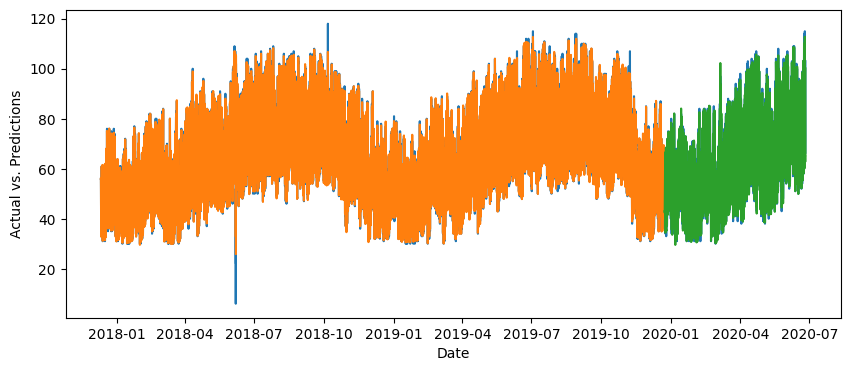

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(actual_pred['date'], actual_pred[["y",'y_pred_train', 'y_pred_test']])
plt.xlabel("Date")
plt.ylabel("Actual vs. Predictions")
plt.show()

### (2.4) Variable Explanations

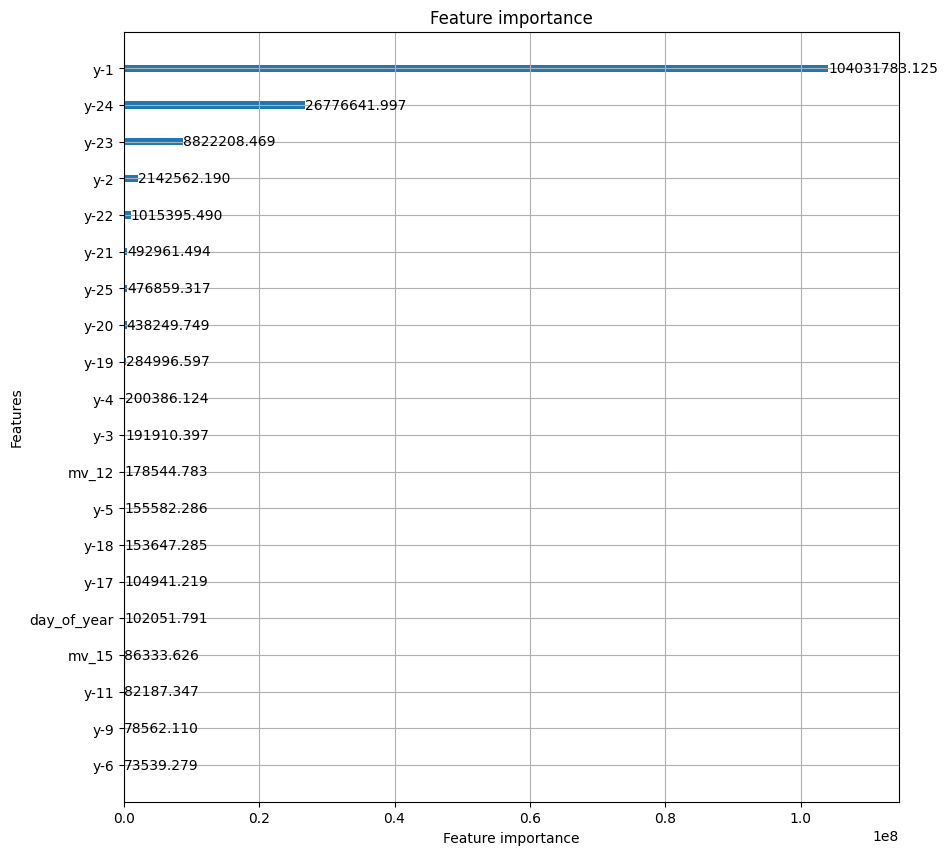

In [ ]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()